In [32]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [33]:
# Configure paths and feature settings
PROJECT_ROOT = Path.cwd().parent
CLEAN_DIR = PROJECT_ROOT / 'preprocessed_data'
OUT_DIR = PROJECT_ROOT / 'feature_matrices'
OUT_DIR.mkdir(exist_ok=True)

# Feature settings
TFIDF_MAX_FEAT = 10000
TFIDF_NGRAMS = (1, 2)
SVD_COMPONENTS = 300
NUM_COLS = ['goal', 'pledged', 'usd_pledged', 'duration_days', 'pledged_to_goal', 'backers']
CAT_COLS = ['main_category', 'currency', 'state']

# Model settings
RANDOM_STATE = 42

In [34]:
# Load and align datasets
csv_files = glob.glob(os.path.join(CLEAN_DIR, '*.csv'))
if len(csv_files) < 1:
    raise ValueError(f"No CSV files found in {CLEAN_DIR}")

print(f"Found {len(csv_files)} CSV files in {CLEAN_DIR}")

# Load datasets
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    # Rename columns for consistency
    rename_dict = {
        'amt.pledged': 'pledged',
        'title': 'name',
        'num.backers': 'backers',
        'end.time': 'deadline',
        'percentage.funded': 'pledged_to_goal_ratio',
        'usd_pledged': 'usd_pledged'
    }
    df.rename(columns=rename_dict, inplace=True)
    # Ensure common columns
    common_cols = [
        'name', 'blurb', 'category', 'main_category', 'currency', 'deadline',
        'goal', 'launched', 'pledged', 'state', 'backers', 'country',
        'usd_pledged', 'pledged_to_goal_ratio'
    ]
    # Add missing columns
    for col in common_cols:
        if col not in df.columns:
            if col in ['name', 'blurb']:
                df[col] = ''
            elif col in ['category', 'main_category', 'currency', 'country', 'state']:
                df[col] = 'unknown'
            else:
                df[col] = np.nan
    df = df[common_cols]
    dfs.append(df)

# Concatenate datasets
data = pd.concat(dfs, ignore_index=True)
print("Combined dataset shape:", data.shape)
print("Columns:", data.columns.tolist())

Found 4 CSV files in /home/lance/CODEWRLD/ICS4A/ML/crowdfundingproject/preprocessed_data
Combined dataset shape: (710411, 14)
Columns: ['name', 'blurb', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged', 'pledged_to_goal_ratio']


In [35]:
# Handle missing data and engineer features
# Inspect column data types
print("Column data types:\n", data.dtypes)

# Convert numerical columns to float, coercing invalid values to NaN
num_cols_to_fix = ['goal', 'pledged', 'backers', 'usd_pledged']
for col in num_cols_to_fix:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    if data[col].dtype not in ['float64', 'int64']:
        print(f"Warning: Column {col} still contains non-numeric values after coercion.")
        print(data[col].head())

# Missing data
data['name'] = data['name'].fillna('')
data['blurb'] = data['blurb'].fillna('')
data['category'] = data['category'].fillna('unknown')
data['main_category'] = data['main_category'].fillna('unknown')
data['currency'] = data['currency'].fillna('unknown')
data['country'] = data['country'].fillna('unknown')
data['state'] = data['state'].fillna('unknown')
data['deadline'] = pd.to_datetime(data['deadline'], errors='coerce').fillna(pd.Timestamp('2020-01-01'))
data['launched'] = pd.to_datetime(data['launched'], errors='coerce').fillna(pd.Timestamp('2020-01-01'))
data[num_cols_to_fix] = data[num_cols_to_fix].fillna(data[num_cols_to_fix].median())
data['pledged_to_goal_ratio'] = data['pledged_to_goal_ratio'].fillna(data['pledged'] / data['goal'].replace(0, 1))

# Engineer features
data['duration_days'] = (data['deadline'] - data['launched']).dt.days.clip(lower=1)
data['pledged_to_goal'] = data['pledged'] / data['goal'].replace(0, 1)

# Engineer fraud label
data['fraud_label'] = (
    ((data['goal'] > 500000) & (data['backers'] < 20)) |  # High goal, low backers
    ((data['state'] == 'failed') & (data['pledged_to_goal'] < 0.1) & (data['duration_days'] < 15))  # Failed, low funding, short duration
).astype(int)
print("Fraud label distribution:\n", data['fraud_label'].value_counts())
print("Missing values:\n", data.isnull().sum())

Column data types:
 name                      object
blurb                     object
category                  object
main_category             object
currency                  object
deadline                  object
goal                     float64
launched                  object
pledged                  float64
state                     object
backers                   object
country                   object
usd_pledged               object
pledged_to_goal_ratio    float64
dtype: object
Fraud label distribution:
 fraud_label
0    702938
1      7473
Name: count, dtype: int64
Missing values:
 name                     0
blurb                    0
category                 0
main_category            0
currency                 0
deadline                 0
goal                     0
launched                 0
pledged                  0
state                    0
backers                  0
country                  0
usd_pledged              0
pledged_to_goal_ratio    0
duration_days       

In [36]:
# Initialize feature extractors
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEAT, ngram_range=TFIDF_NGRAMS, stop_words='english')
svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=RANDOM_STATE)
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

In [ ]:
# Extract features
# Identify columns
text_col = 'blurb' if data['blurb'].str.strip().ne('').any() else 'name'
num_cols = ['goal', 'pledged', 'usd_pledged', 'duration_days', 'pledged_to_goal', 'backers']
cat_cols = ['main_category', 'currency', 'state']

print("Text column:", text_col)
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Text features: TF-IDF + SVD
try:
    X_tfidf = tfidf.fit_transform(data[text_col])
    X_svd = svd.fit_transform(X_tfidf)
    print("SVD components shape:", X_svd.shape)
except Exception as e:
    print(f"Error in TF-IDF/SVD: {e}")
    X_svd = np.zeros((len(data), SVD_COMPONENTS))

# Numerical features: Scale
try:
    if num_cols and not data[num_cols].isnull().all().any():
        X_num = scaler.fit_transform(data[num_cols])
        print("Numeric matrix shape:", X_num.shape)
    else:
        X_num = np.empty((len(data), 0))
        print("No valid numeric columns.")
except Exception as e:
    print(f"Error in scaling numerical features: {e}")
    X_num = np.empty((len(data), 0))

# Categorical features: One-hot encode
try:
    if cat_cols:
        X_cat = ohe.fit_transform(data[cat_cols])
        print("Categorical matrix shape:", X_cat.shape)
    else:
        X_cat = csr_matrix((len(data), 0))
        print("No categorical columns.")
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    X_cat = csr_matrix((len(data), 0))

# Combine features
try:
    X_all = hstack([csr_matrix(X_svd), X_cat, csr_matrix(X_num)]).tocsr()
    print("Combined feature matrix shape:", X_all.shape)
except Exception as e:
    print(f"Error combining features: {e}")
    X_all = csr_matrix((len(data), 0))

# Save feature matrix and extractors
np.save(OUT_DIR / 'X_all.npy', X_all.toarray())  # Save as dense for compatibility
joblib.dump(tfidf, OUT_DIR / 'tfidf.pkl')
joblib.dump(svd, OUT_DIR / 'svd.pkl')
joblib.dump(scaler, OUT_DIR / 'scaler.pkl')
joblib.dump(ohe, OUT_DIR / 'ohe.pkl')
print("Saved extractors: tfidf.pkl, svd.pkl, scaler.pkl, ohe.pkl")

Text column: blurb
Numeric columns: ['goal', 'pledged', 'usd_pledged', 'duration_days', 'pledged_to_goal', 'backers']
Categorical columns: ['main_category', 'currency', 'state']
SVD components shape: (710411, 300)
Numeric matrix shape: (710411, 6)
Categorical matrix shape: (710411, 846)
Combined feature matrix shape: (710411, 1152)


In [ ]:
# Prepare data for modeling
X = X_all
y = data['fraud_label']
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    print("Unique labels in y_test:", np.unique(y_test))
except Exception as e:
    print(f"Error in train-test split: {e}")
    raise

Training set shape: (568328, 1152)
Test set shape: (142083, 1152)
Unique labels in y_test: [0 1]


In [27]:
# Handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)  # Less aggressive oversampling
try:
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("Balanced training label distribution:\n", pd.Series(y_train_bal).value_counts())
except Exception as e:
    print(f"SMOTE failed: {e}. Using original training data.")
    X_train_bal, y_train_bal = X_train, y_train

Balanced training label distribution:
 fraud_label
0    562350
1    562350
Name: count, dtype: int64



Random Forest Classification Report:

              precision    recall  f1-score   support

  Legitimate       1.00      0.75      0.86    140588
  Fraudulent       0.04      0.99      0.08      1495

    accuracy                           0.76    142083
   macro avg       0.52      0.87      0.47    142083
weighted avg       0.99      0.76      0.85    142083

Random Forest ROC-AUC: 0.9947803220739497


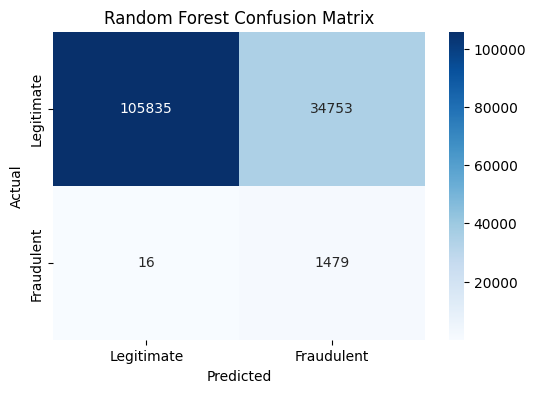

In [ ]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=20,
    min_samples_split=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
try:
    rf_model.fit(X_train_bal, y_train_bal)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    print("\nRandom Forest Classification Report:\n")
    print(classification_report(y_test, y_pred_rf, target_names=['Legitimate', 'Fraudulent']))
    print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
    plt.title('Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
except Exception as e:
    print(f"Error in Random Forest training/evaluation: {e}")


XGBoost Classification Report:

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    140588
  Fraudulent       0.81      1.00      0.90      1495

    accuracy                           1.00    142083
   macro avg       0.91      1.00      0.95    142083
weighted avg       1.00      1.00      1.00    142083

XGBoost ROC-AUC: 0.999951488982775


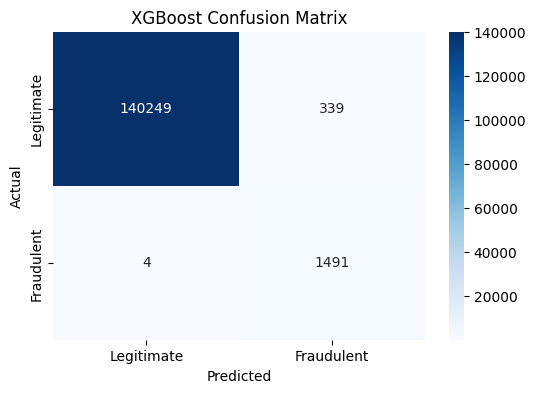

In [ ]:
# Train XGBoost
scale_pos_weight = max(1.0, (y_train == 0).sum() / (y_train == 1).sum())
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
try:
    xgb_model.fit(X_train_bal, y_train_bal)
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    if np.any(np.isnan(y_pred_proba_xgb)):
        print("Warning: NaN predictions in XGBoost. Replacing with 0.")
        y_pred_proba_xgb = np.nan_to_num(y_pred_proba_xgb, nan=0.0)
    print("\nXGBoost Classification Report:\n")
    print(classification_report(y_test, y_pred_xgb, target_names=['Legitimate', 'Fraudulent']))
    print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))

    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
except Exception as e:
    print(f"Error in XGBoost training/evaluation: {e}")

/home/lance/CODEWRLD/ICS4A/ML/crowdfundingproject/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Classification Report:

              precision    recall  f1-score   support

  Legitimate       1.00      0.81      0.90    140588
  Fraudulent       0.05      0.99      0.10      1495

    accuracy                           0.81    142083
   macro avg       0.53      0.90      0.50    142083
weighted avg       0.99      0.81      0.89    142083

Logistic Regression ROC-AUC: 0.9593538576107438


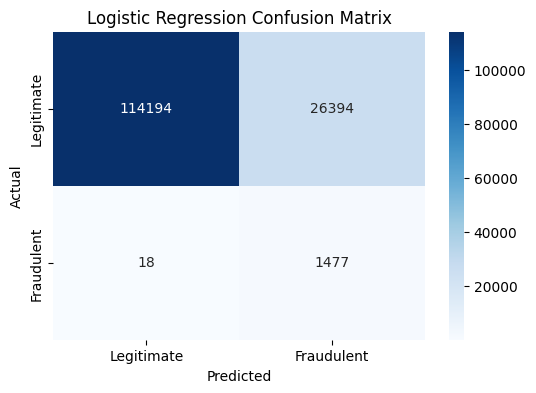

In [ ]:
# Train Logistic Regression
lr_model = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='saga', 
    C=0.01, 
    max_iter=1000, 
    random_state=RANDOM_STATE
)
try:
    lr_model.fit(X_train_bal, y_train_bal)
    y_pred_lr = lr_model.predict(X_test)
    y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    if np.any(np.isnan(y_pred_proba_lr)):
        print("Warning: NaN predictions detected in Logistic Regression.")
        y_pred_proba_lr = np.nan_to_num(y_pred_proba_lr, nan=0.0)
    print("\nLogistic Regression Classification Report:\n")
    print(classification_report(y_test, y_pred_lr, target_names=['Legitimate', 'Fraudulent']))
    print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_pred_proba_lr))

    cm_lr = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
    plt.title('Logistic Regression Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
except Exception as e:
    print(f"Error in Logistic Regression training/evaluation: {e}")

In [ ]:
# Compare models and save
models = {'Random Forest': rf_model, 'XGBoost': xgb_model, 'Logistic Regression': lr_model}
results = {}
print("Unique labels in y_test:", np.unique(y_test))  # Debug labels

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        if np.any(np.isnan(y_pred_proba)):
            print(f"Warning: NaN predictions in {name}. Replacing with 0.")
            y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.0)
        report = classification_report(y_test, y_pred, output_dict=True, labels=[0, 1], target_names=['Legitimate', 'Fraudulent'])
        results[name] = {
            'F1-Score (Fraud)': report['Fraudulent']['f1-score'],
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        }
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        results[name] = {'F1-Score (Fraud)': 0, 'ROC-AUC': 0}

results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

# Save models
import joblib
joblib.dump(rf_model, OUT_DIR / 'rf_fraud_model.pkl')
joblib.dump(xgb_model, OUT_DIR / 'xgb_fraud_model.pkl')
joblib.dump(lr_model, OUT_DIR / 'lr_fraud_model.pkl')

Unique labels in y_test: [0 1]

Model Comparison:
                      F1-Score (Fraud)   ROC-AUC
Random Forest                0.078405  0.994780
XGBoost                      0.896842  0.999951
Logistic Regression          0.100593  0.959354


['/home/lance/CODEWRLD/ICS4A/ML/crowdfundingproject/feature_matrices/lr_fraud_model.pkl']